<a href="https://colab.research.google.com/github/Ramkanc/Capstone_flickr30K/blob/main/Capstone1_V2__MultiModal_Similarity30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import gdown

In [ ]:
# Replace 'file_id' with the actual file ID from the Google Drive share link
#text embedding 'https://drive.google.com/file/d/17icNB_CL7CKP-k3vn0reBpWmrzLb25fn/view?usp=drive_link'
file_id_a = '17icNB_CL7CKP-k3vn0reBpWmrzLb25fn'  # Replace with your file ID
output_file = 'txt_embedding.zip'
gdown.download(id=file_id_a, output = output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn
From (redirected): https://drive.google.com/uc?id=17icNB_CL7CKP-k3vn0reBpWmrzLb25fn&confirm=t&uuid=6113c936-dd82-4e6f-884d-91b8e24f2ce7
To: /content/txt_embedding.zip
100%|██████████| 412M/412M [00:02<00:00, 179MB/s]


'txt_embedding.zip'

In [ ]:
!unzip /content/txt_embedding.zip -d /content/txt_embedding

Streaming output truncated to the last 5000 lines.
  inflating: /content/txt_embedding/6840400032_2.pt  
  inflating: /content/txt_embedding/4975012108_2.pt  
  inflating: /content/txt_embedding/5871124252_2.pt  
  inflating: /content/txt_embedding/3666796674_3.pt  
  inflating: /content/txt_embedding/2943375194_1.pt  
  inflating: /content/txt_embedding/3415578043_2.pt  
  inflating: /content/txt_embedding/7713053118_4.pt  
  inflating: /content/txt_embedding/2214322704_1.pt  
  inflating: /content/txt_embedding/2480000122_1.pt  
  inflating: /content/txt_embedding/520491467_1.pt  
  inflating: /content/txt_embedding/4697182982_2.pt  
  inflating: /content/txt_embedding/2925737498_3.pt  
  inflating: /content/txt_embedding/6493393907_5.pt  
  inflating: /content/txt_embedding/5831085623_1.pt  
  inflating: /content/txt_embedding/4816480417_5.pt  
  inflating: /content/txt_embedding/4579716766_4.pt  
  inflating: /content/txt_embedding/2534424894_3.pt  
  inflating: /content/txt_embedd

In [ ]:
#image embedding 'https://drive.google.com/file/d/1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua/view?usp=drive_link'
file_id_b = '1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua'  # Replace with your file ID
output_file = 'img_embedding.zip'
gdown.download(id=file_id_b, output = output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua
From (redirected): https://drive.google.com/uc?id=1IA76FH2ks65AtjCUCoa52fJ7vlNGuLua&confirm=t&uuid=d72e4e11-d419-45b7-b4f2-d6e5a9d5f5d7
To: /content/img_embedding.zip
100%|██████████| 82.3M/82.3M [00:00<00:00, 157MB/s]


'img_embedding.zip'

In [ ]:
!unzip /content/img_embedding.zip -d /content/img_embedding

Streaming output truncated to the last 5000 lines.
  inflating: /content/img_embedding/13255060.pt  
  inflating: /content/img_embedding/2114739371.pt  
  inflating: /content/img_embedding/3013469764.pt  
  inflating: /content/img_embedding/479807833.pt  
  inflating: /content/img_embedding/27463274.pt  
  inflating: /content/img_embedding/4725668536.pt  
  inflating: /content/img_embedding/8052575239.pt  
  inflating: /content/img_embedding/4932212272.pt  
  inflating: /content/img_embedding/7247347662.pt  
  inflating: /content/img_embedding/132991765.pt  
  inflating: /content/img_embedding/2886225006.pt  
  inflating: /content/img_embedding/3275241472.pt  
  inflating: /content/img_embedding/4797178138.pt  
  inflating: /content/img_embedding/530661899.pt  
  inflating: /content/img_embedding/4622993220.pt  
  inflating: /content/img_embedding/2415402073.pt  
  inflating: /content/img_embedding/2212794589.pt  
  inflating: /content/img_embedding/4745172392.pt  
  inflating: /conten

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import re
import pickle

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, img_dir, txt_dir):
        """
        Args:
            img_dir (str): Path to the directory containing image embeddings (.pt files).
            txt_dir (str): Path to the directory containing text embeddings (.pt files).
        """
        self.img_dir = img_dir
        self.txt_dir = txt_dir

        # Load all image embedding filenames
        self.image_files = [
            f for f in os.listdir(img_dir) if f.endswith('.pt')
        ]

        # Ensure corresponding text embeddings exist
        self.dataset = []
        for img_file in self.image_files:
            base_name = os.path.splitext(img_file)[0]
            for suffix in range(1, 6):  # Assuming suffix ranges from 1 to 5
                txt_file = f"{base_name}_{suffix}.pt"
                txt_path = os.path.join(txt_dir, txt_file)
                if os.path.exists(txt_path):
                    self.dataset.append((os.path.join(img_dir, img_file), txt_path))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, txt_path = self.dataset[idx]

        # Load image embedding
        img_tensor = torch.load(img_path, weights_only=True)

        # Load text embedding
        txt_tensor = torch.load(txt_path, weights_only=True)

        return img_tensor, txt_tensor

In [ ]:
image_directory = '/content/img_embedding'
text_directory = '/content/txt_embedding'

In [ ]:
dataset_instance = EmbeddingDataset(image_directory, text_directory)

In [ ]:
print(f"Total samples in the dataset: {len(dataset_instance)}")

Total samples in the dataset: 158915


In [ ]:
# Access a sample
img_tensor, txt_tensor = dataset_instance[0]
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Text tensor shape: {txt_tensor.shape}")

Image tensor shape: torch.Size([1, 512])
Text tensor shape: torch.Size([1, 512])


In [ ]:
for i in range(3):  # Display the first 3 samples
    img_tensor, txt_tensor = dataset_instance[i]
    print(f"Sample {i + 1}:")
    print(f"Image Tensor Shape: {img_tensor.shape}")
    print(f"Text Tensor Shape: {txt_tensor.shape}")


Sample 1:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])
Sample 2:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])
Sample 3:
Image Tensor Shape: torch.Size([1, 512])
Text Tensor Shape: torch.Size([1, 512])


In [ ]:
# Create a DataLoader
batch_size = 35
dataloader = DataLoader(dataset_instance, batch_size=batch_size, shuffle=True)

# Iterate through DataLoader
for batch_idx, (img_batch, txt_batch) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Image Batch Shape: {img_batch.shape}")
    print(f"Text Batch Shape: {txt_batch.shape}")
    break  # Display only the first batch

Batch 1:
Image Batch Shape: torch.Size([35, 1, 512])
Text Batch Shape: torch.Size([35, 1, 512])


In [ ]:
# Initialize counters for global accuracy calculation
total_correct = 0
total_samples = 0

# Process all batches
for batch_idx, (img_batch, txt_batch) in enumerate(dataloader):
    # Move batches to the same device
    img_batch = img_batch.to(device)
    txt_batch = txt_batch.to(device)

    # Get the actual batch size for the current batch (could be smaller than 35 for the last batch)
    current_batch_size = img_batch.size(0)

    # Reduce dimensions via mean pooling
    img_reduced = img_batch.mean(dim=1)  # Shape: [current_batch_size, embedding_dim]
    txt_reduced = txt_batch.mean(dim=1)  # Shape: [current_batch_size, embedding_dim]

    # Normalize embeddings for cosine similarity
    #img_norm = F.normalize(img_reduced, p=2, dim=1)  # Normalize image embeddings
    img_norm = F.normalize(img_reduced, dim=-1)
    #txt_norm = F.normalize(txt_reduced, p=2, dim=1)  # Normalize text embeddings
    txt_norm = F.normalize(txt_reduced, dim=-1)
    print(f"Image Norm Shape: {img_norm.shape}")
    print(f"Text Norm Shape: {txt_norm.shape}")

    # Compute similarity matrix (cosine similarity)
    similarity_matrix = torch.mm(img_norm, txt_norm.t())  # Shape: [current_batch_size, current_batch_size]

    # Find the most similar text embedding for each image embedding
    most_similar_idx = torch.argmax(similarity_matrix, dim=1)  # Shape: [current_batch_size]

    # Calculate accuracy
    ground_truth = torch.arange(current_batch_size, device=device)  # [0, 1, 2, ..., current_batch_size - 1]
    correct_predictions = (most_similar_idx == ground_truth).sum().item()
    total_correct += correct_predictions
    total_samples += current_batch_size

    batch_accuracy = correct_predictions / current_batch_size * 100  # Accuracy for this batch
    print(f"Batch {batch_idx + 1}:")
    #print(f"  Similarity Matrix: \n{similarity_matrix}")
    print(f"  Predicted Indices: {most_similar_idx}")
    print(f"  Ground Truth: {ground_truth}")
    print(f"  Accuracy: {batch_accuracy:.2f}%")

# Global accuracy
global_accuracy = total_correct / total_samples * 100
print(f"\nOverall Accuracy: {global_accuracy:.2f}%")


Streaming output truncated to the last 5000 lines.
Image Norm Shape: torch.Size([35, 512])
Text Norm Shape: torch.Size([35, 512])
Batch 4042:
  Predicted Indices: tensor([29,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21,  9, 24, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       device='cuda:0')
  Ground Truth: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
       device='cuda:0')
  Accuracy: 91.43%
Image Norm Shape: torch.Size([35, 512])
Text Norm Shape: torch.Size([35, 512])
Batch 4043:
  Predicted Indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 14, 31, 32, 33, 34],
       device='cuda:0')
  Ground Truth: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
print (device)

cuda


In [ ]:
# Load image embeddings from the folder `img_embedding`
img_embedding_folder = 'img_embedding'
image_embeddings = []
image_paths = []

In [ ]:
# Load all the embeddings from .pt files in the folder
for filename in os.listdir(img_embedding_folder):
    if filename.endswith(".pt"):
        # Construct the full file path
        file_path = os.path.join(img_embedding_folder, filename)

        # Load the embedding from the .pt file
        embedding = torch.load(file_path, weights_only=True)  # Shape: [embedding_dim]

        # Assuming the filename (without extension) is the image name
        image_name = filename.split('.')[0]  # Remove .pt extension to get image name

        # Append the embedding and image path to the lists
        image_embeddings.append(embedding)
        image_paths.append(image_name)

# Convert the list of embeddings to a tensor and move to the same device
image_embeddings = torch.stack(image_embeddings).to(device)  # Shape: [num_images, embedding_dim]
image_embeddings = image_embeddings.squeeze(1)

# Normalize image embeddings
image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

In [ ]:
print(f"Image Embeddings Shape: {image_embeddings.shape}")
print(f"Image Paths: {image_paths}")

Image Embeddings Shape: torch.Size([31783, 512])
Image Paths: ['497791037', '6964379609', '332616045', '252124738', '3716277216', '3695949492', '3642570796', '140526326', '2385522475', '4523790717', '3114664900', '5385069995', '47414435', '3873835329', '2383642818', '4882682075', '3458379941', '2341755936', '2609133063', '2916362709', '4848505381', '4046178292', '143149186', '3535511987', '8029536', '4799239390', '3090398639', '3514685438', '2216631622', '5399620276', '3815075229', '4887197185', '7006400639', '3644945293', '4738563006', '531124063', '3396625253', '395248604', '4392524083', '2394824046', '2588927489', '4952298835', '7520893644', '7519792774', '6939695046', '4761370497', '4660946919', '3215695965', '4509183066', '2119206841', '4717521897', '2929137203', '3624246111', '6800762956', '135235570', '3789230623', '3978673802', '3643087589', '6592762245', '3819480825', '4550055382', '5690804296', '191592626', '6818875863', '343830875', '3249891130', '6201295346', '3694931544', 

In [ ]:
def retrieve_image_from_text(text_query):
    # Encode the text query
    text_inputs = processor(text=[text_query], return_tensors="pt", padding=True).to(device)#, truncation=True)

    # Extract text embeddings
    with torch.no_grad():
      text_embeddings = model.get_text_features(**text_inputs)

    # Normalize text embeddings
    text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=-1, keepdim=True).to(device)

    print(f"Text Query: {text_query}")
    print(f"Text Embeddings Shape: {text_embeddings.shape}")

    # Ensure that text embeddings are 2D and image embeddings are 2D
    # if text_embeddings.dim() == 1:
    #     text_embeddings = text_embeddings.unsqueeze(0)  # Make it [1, embedding_dim]
    # Ensure that text and image embeddings are on the same device


    # Calculate cosine similarity between the text and image embeddings
    similarity_scores = torch.mm(text_embeddings, image_embeddings.T)  # Shape: [1, num_images]

    # Get the index of the most similar image
    most_similar_idx = torch.argmax(similarity_scores, dim=1).item()

    # Retrieve the corresponding image path
    retrieved_image_name = image_paths[most_similar_idx]
    retrieved_score = similarity_scores[0][most_similar_idx].item()

    return retrieved_image_name, retrieved_score

In [ ]:
!kaggle datasets download -d eeshawn/flickr30k
!unzip flickr30k.zip

Dataset URL: https://www.kaggle.com/datasets/eeshawn/flickr30k
License(s): other
flickr30k.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flickr30k.zip
replace captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
# Example usage
text_query = "A man with teddy bear"
best_image_name, similarity_score = retrieve_image_from_text(text_query)
print(f"Retrieved Image: {best_image_name}, Similarity Score: {similarity_score}")

Text Query: A man with teddy bear
Text Embeddings Shape: torch.Size([1, 512])
Retrieved Image: 1000919630, Similarity Score: 0.30073490738868713


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

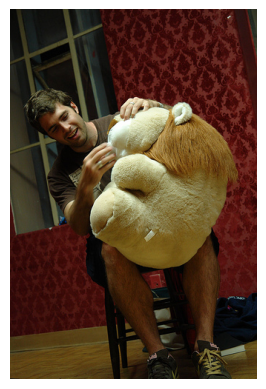

In [ ]:
im_path = f"/content/flickr30k_images/{best_image_name}.jpg"
img = Image.open(im_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
caption_embedding_folder = 'txt_embedding'
caption_embeddings_lst = []
captions_lst = []

In [ ]:
for filename in os.listdir(caption_embedding_folder):
    if filename.endswith(".pt"):
        file_path = os.path.join(caption_embedding_folder, filename)
        embedding = torch.load(file_path, weights_only=True).to(device)
        embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)
        caption_embeddings_lst.append(embedding)
        captions_lst.append(filename)

In [ ]:
captions_file = "/content/captions.txt"
def extract_third_part(caption_heading):
    """
    Opens a file, finds a specific line, splits it, and returns the third part.


    Args:
        filename (str): The name of the file to open. Defaults to "captions.txt".

    Returns:
        str: The third part of the split line, or None if the line is not found.
    """
    #filename = os.path.join("/content/",{filename})
    caption_heading = caption_heading.split(".")[0]
    caption_heading = caption_heading.replace("_", ".jpg,")
    print(f"Caption index is : {caption_heading}")
    try:
        with open(captions_file, "r") as file:  # Open the file in read-only mode
            for line in file:  # Iterate through each line
                if caption_heading in line:  # Check if the line contains the target phrase
                    parts = line.strip().split(",")  # Split the line by commas
                    if len(parts) >= 3:  # Ensure there are at least 3 parts
                        return parts[2]  # Return the third part
                    else:
                        print("Line does not have 3 parts after splitting.")
                        return None
            print("Line containing 'best_caption_idx' not found in the file.")
            return None  # Return None if the line is not found
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        return None

# Example usage
# result = extract_third_part("3660303751_4.pt")
# if result:
#     print(f"The third part is: {result}")

In [ ]:
# Assuming you're using CLIP to extract features and define a set of captions
def generate_caption_from_image(image_path):

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True).to(device)

    # Extract image features
    with torch.no_grad():
        image_embed = model.get_image_features(**inputs)
    # Normalize the embeddings
    image_embed = image_embed / image_embed.norm(p=2, dim=-1, keepdim=True).to(device)
    #print(f"Image Embeddings Shape: {image_embed.shape}")

    # Caption embeddings to tensors
    caption_embeddings_stk = torch.stack(caption_embeddings_lst).to(device)
    caption_embeddings_stk = caption_embeddings_stk.squeeze(1)
    #print(f"Caption Embeddings Shape: {caption_embeddings_stk.shape}")


    # Compute similarity scores (cosine similarity)
    similarity_scores = torch.mm(image_embed, caption_embeddings_stk.T)  # Shape: [1, num_templates]
    best_caption_idx = torch.argmax(similarity_scores, dim=1).item()
    print(f"Best Similarity score is : ", torch.argmax(similarity_scores, dim=1))

    extracted_caption = extract_third_part(captions_lst[best_caption_idx])
    #print(f"Extracted Caption: {extracted_caption}")

    # Return the best caption for the image
    return extracted_caption

Best Similarity score is :  tensor([104071], device='cuda:0')
Caption index is : 3660303751.jpg,4
Generated Caption: A man is sitting in a harness and washing a window .


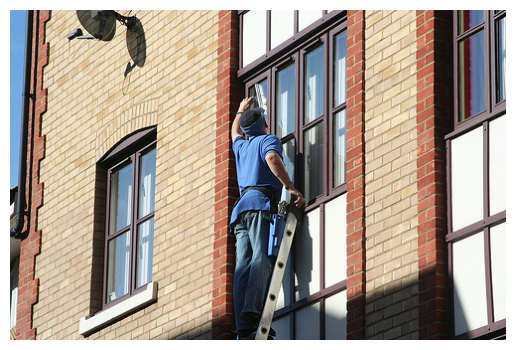

In [ ]:
# Example usage
image_path = "/content/flickr30k_images/1000344755.jpg"
caption = generate_caption_from_image(image_path)
print(f"Generated Caption: {caption}")
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

streamlit

In [3]:
# prompt: please guide the steps in deploying this modal in to the server

!pip install streamlit
!pip install pyngrok

# Save the code as app.py
%%writefile app.py
import streamlit as st
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

# ... (rest of your existing code) ...

st.title("Image Captioning App")

# File uploader for image input
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Generate caption
    caption = generate_caption_from_image(uploaded_file)
    st.write(f"Generated Caption: {caption}")

# For text query
text_query = st.text_input("Enter a text query:")

if st.button("Retrieve Image"):
  if text_query:
      best_image_name, similarity_score = retrieve_image_from_text(text_query)
      st.write(f"Retrieved Image: {best_image_name}, Similarity Score: {similarity_score}")
      im_path = f"/content/flickr30k_images/{best_image_name}.jpg"

      try:
        img = Image.open(im_path)
        st.image(img, caption=f"Retrieved Image: {best_image_name}", use_column_width=True)
      except FileNotFoundError:
        st.error(f"Image not found at {im_path}")
  else:
      st.warning("Please enter a text query.")


# Run the Streamlit app
from pyngrok import ngrok
public_url = ngrok.connect(port='8501')
print (public_url)
!streamlit run app.py &>/dev/null&

UsageError: Line magic function `%%writefile` not found.
